In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
from util import *
df = pd.read_csv("movies.csv")
df = df.drop(columns=[
    "id", 
    # "title", 
    "status", 
    # "release_date", # TODO: this is temporary, might keep this column
    "production_companies", 
    "credits", 
    "poster_path", 
    "backdrop_path", 
    "recommendations", 
    "keywords", 
    "tagline"
])

df = df[
    (df["budget"] > 0)
    & (df["revenue"] > 0)
    & (df["vote_count"] > 10)
    & (df["vote_average"] > 0)
    & (df["runtime"] > 0)
]
df = df.drop_duplicates(subset=["title", "release_date"])
df = df.drop(columns=["release_date", "title"])
df = df.dropna(subset=["genres", "runtime", "overview"])
languages_to_keep = df["original_language"].value_counts().nlargest(15).index
df["original_language"] = df["original_language"].apply(lambda row: row if row in languages_to_keep else "other")
cols_to_adjust = ["popularity", "budget", "revenue", "vote_count"]
for i in cols_to_adjust: 
    thresh_lower = df[i].quantile(0.05)
    thresh_upper = df[i].quantile(0.95)
    df[i] = df[i].clip(lower=thresh_lower, upper=thresh_upper)
df.describe()
df["profit_margin"] = profit_margin(df["budget"], df["revenue"])
profit_margin_lower = df["profit_margin"].quantile(0.05)
profit_margin_upper = df["profit_margin"].quantile(0.95)
df["profit_margin"] = df["profit_margin"].clip(lower=profit_margin_lower, upper=profit_margin_upper)
df["profit_margin"] = np.exp(df["profit_margin"])
# df = df.drop(columns="revenue")
df.head()

,genres,original_language,overview,popularity,budget,revenue,runtime,vote_average,vote_count,profit_margin
0,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,64.9115,105000000.0,349946693.5,116.0,7.079,1365.0,2.013661
1,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,64.9115,18000000.0,65675816.0,103.0,7.433,545.0,2.066645
2,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,64.9115,105000000.0,349946693.5,127.0,7.340,1007.0,2.013661
3,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,64.9115,105000000.0,349946693.5,125.0,6.507,2811.0,2.013661
4,Drama-Action,en,After dominating the boxing world Adonis Creed...,64.9115,75000000.0,269000000.0,116.0,7.262,1129.0,2.056879


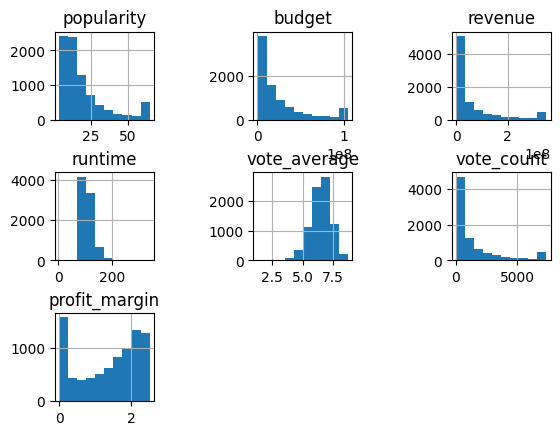

In [137]:
df.hist()
plt.subplots_adjust(wspace=1, hspace=0.6)
plt.show()

In [138]:
cols_to_log_normalize = ["popularity", "budget", "vote_count"]
cols_to_min_max_normalize = ["popularity", "budget", "runtime", "vote_average", "vote_count"]
# get the mins and maxs so we can translate the profit margin (label) back to its actual value
for i in cols_to_log_normalize:
    df[i] = np.log1p(df[i])
mins = df[cols_to_min_max_normalize].min()
maxs = df[cols_to_min_max_normalize].max()
min_max_df = pd.DataFrame({"min": mins, "max": maxs})
min_max_df.to_csv("min_maxs.csv")
for i in cols_to_min_max_normalize:
    min_val = df[i].min()
    max_val = df[i].max()
    df[i] = (df[i] - min_val) / (max_val - min_val)



In [139]:
df = multihot_tf_idf(df, "overview")
df = multihot_column(df, "-", "genres")
df = pd.get_dummies(df, columns=["original_language"], dtype=int)

In [140]:
df = df.drop(columns="revenue")
# get the 80% for training
train, test = train_test_split(df, test_size=0.2)
# split the remaining into 10 and 10
val, test = train_test_split(test, test_size=0.5)
train.to_csv("train.csv", index=False)
val.to_csv("validation.csv", index=False)
test.to_csv("test.csv", index=False)

In [141]:
train.shape, val.shape, test.shape

((6716, 61), (840, 61), (840, 61))

In [142]:
train.columns

Index(['popularity', 'budget', 'runtime', 'vote_average', 'vote_count',
       'profit_margin', 'overview: life', 'overview: new', 'overview: young',
       'overview: world', 'overview: man', 'overview: family',
       'overview: love', 'overview: woman', 'overview: story',
       'overview: finds', 'overview: old', 'overview: time',
       'overview: father', 'overview: friends', 'overview: years',
       'overview: war', 'overview: help', 'overview: wife', 'overview: town',
       'overview: school', 'genres: Documentary', 'genres: Romance',
       'genres: Animation', 'genres: Family', 'genres: Mystery',
       'genres: Adventure', 'genres: Comedy', 'genres: Music', 'genres: War',
       'genres: TV Movie', 'genres: Fantasy', 'genres: Western',
       'genres: Action', 'genres: Horror', 'genres: History', 'genres: Drama',
       'genres: Thriller', 'genres: Science Fiction', 'genres: Crime',
       'original_language_cn', 'original_language_de', 'original_language_en',
       'orig